# Extended Research Project Model Development (kNN)

## 1. Preprocess the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
pip install optuna

In [6]:
# === Step 0: Import Libraries ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
import optuna
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [7]:
# === Step 1: Data Preparation ===
# load the data
df = pd.read_csv("/content/drive/MyDrive/ERP/KNN/Final_bayes_knn_ols_svm_svd.csv.gz", compression="gzip")

df

,net_income_usd,total_assets_usd,shareholders_funds_usd,capital_usd,revenue_usd,schooling_years_2020,urban_pop_growth_2022,logistics_index_2018,life_expectancy_2022,female_labor_participation_2023,...,svd_91,svd_92,svd_93,svd_94,svd_95,svd_96,svd_97,svd_98,svd_99,svd_100
0,9.447491e+05,0.181549,NaN,-0.003279,3.541786e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0.013482,-0.023297,-0.026130,-0.019788,0.008973,-0.005500,-0.019473,-0.009817,0.011526,-0.029350
1,1.765783e+04,0.181549,0.098608,0.040249,1.437969e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0.012744,0.026045,0.019724,0.076969,0.012354,-0.062352,-0.000067,0.075836,-0.045383,0.066350
2,-2.502728e+04,0.181549,-0.168453,0.040249,1.246335e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0.006091,0.001558,-0.050122,0.024515,0.019798,-0.018739,-0.008884,-0.005824,0.011487,0.007655
3,1.023630e+03,0.181549,0.020692,0.028005,7.675140e+05,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,-0.001193,-0.001749,0.001392,0.000009,-0.001890,-0.003163,-0.002057,-0.000404,0.000297,-0.000742
4,6.034728e+02,0.181549,0.013782,0.028005,7.037159e+05,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0.000117,0.000087,0.000720,0.000368,-0.000447,0.000312,0.000811,0.000741,-0.000101,-0.000551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477072,-9.593861e+03,0.181549,0.188289,0.040249,-7.980458e+03,-2.574365,2.371344,-1.654855,-1.126116,-1.398460,...,-0.005517,0.001996,0.077717,-0.047973,-0.012855,0.029138,-0.006654,0.009551,-0.004272,-0.026978
477073,-1.343988e+04,-0.028028,-0.004174,0.040249,-1.343954e+04,-2.574365,2.371344,-1.654855,-1.126116,-1.398460,...,-0.001345,0.001982,-0.014596,0.005058,0.005936,-0.001358,-0.003218,0.003140,0.005679,-0.002221
477074,-1.027999e+05,0.181549,0.126416,0.040249,-9.145863e+04,-0.702729,0.619942,0.842805,0.877332,-0.384113,...,-0.001433,0.003882,0.002399,-0.002214,-0.000403,0.002592,-0.000637,0.000756,-0.001343,-0.000120
477075,-7.534849e+01,-0.024172,0.000283,0.000499,-9.680114e+05,-0.702729,0.619942,0.842805,0.877332,-0.384113,...,-0.003776,-0.006383,0.003070,0.000144,-0.000320,0.006390,0.004064,0.001612,-0.001478,0.002275


In [8]:
# create a df for classification
df_cls = df.copy()

# drop NaN
df_cls = df_cls.dropna()
df_cls.isna().sum().sum()

np.int64(0)

In [9]:
def create_success_flag(df):
    """
    Create a binary 'success' column based on revenue, net income, and cash flow thresholds.
    A company is considered successful if:
        - revenue_usd > 455.230 (top quartile)
        - net_income_usd > 0 (profitable)

    Parameters:
        df (pd.DataFrame): Input DataFrame containing startup financial data.

    Returns:
        df_new (pd.DataFrame): DataFrame with the added 'success' column.
        success_counts (pd.Series): Count of 0s and 1s in the 'success' column.
    """

    # Make a copy of the original DataFrame to preserve the input
    df_new = df.copy()

    # Define the success condition as a binary indicator
    # This checks whether all three conditions are met for each row
    df_new["success"] = (
        (df_new["revenue_usd"] > 455.230) &      # Top quartile of revenue
        (df_new["net_income_usd"] > 0)           # Positive net income
    ).astype(int)  # Convert boolean values to 0 or 1

    # Drop the columns used for creating the target to avoid data leakage
    df_new.drop(columns=["revenue_usd", "net_income_usd"], inplace=True)

    # Count how many startups are labeled as success (1) and not success (0)
    success_counts = df_new["success"].value_counts().sort_index()

    return df_new, success_counts

In [10]:
# create a df for classification
df_class, success_counts = create_success_flag(df_cls)
print(df_class["success"])
print(success_counts)

1         1
2         0
3         1
4         1
5         1
         ..
477072    0
477073    0
477074    0
477075    0
477076    0
Name: success, Length: 476920, dtype: int64
success
0    390252
1     86668
Name: count, dtype: int64


In [11]:
# CLASSIFICATION: Define target and feature columns
target_col_cls = "success"
feature_cols_cls = [col for col in df_class.columns if col != target_col_cls]

# Extract features and target
X_cls = df_class[feature_cols_cls].values
y_cls = df_class[target_col_cls].values

# Split into train, validation, and test sets (2D arrays only, no reshape)
X_train_cls, X_temp_cls, y_train_cls, y_temp_cls = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42)
X_val_cls, X_test_cls, y_val_cls, y_test_cls = train_test_split(X_temp_cls, y_temp_cls, test_size=0.5, random_state=42)

## 2. Define the kNN model

In [ ]:
'''
# === Step 2: Define kNN Model for classification===
# CLASSIFICATION: Define kNN model for Classification
class kNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(kNNClassifier, self).__init__()
        self.kNN = nn.kNN(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.kNN(x)             # kNN output
        out = out[:, -1, :]               # Use only last time step
        out = self.fc(out)                # Final classification layer
        return out
'''

'\n# === Step 2: Define kNN Model for classification===\n# CLASSIFICATION: Define kNN model for Classification\nclass kNNClassifier(nn.Module):\n    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):\n        super(kNNClassifier, self).__init__()\n        self.kNN = nn.kNN(input_size, hidden_size, num_layers,\n                            batch_first=True, dropout=dropout)\n        self.fc = nn.Linear(hidden_size, num_classes)\n\n    def forward(self, x):\n        out, _ = self.kNN(x)             # kNN output\n        out = out[:, -1, :]               # Use only last time step\n        out = self.fc(out)                # Final classification layer\n        return out\n'

## 3. Tune hyperparameters by Optuna

In [ ]:
# === Step 3: Optuna Hyperparameter Tuning for kNN Classification ===
def objective_knn_cls(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 1, 20)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    p = trial.suggest_int("p", 1, 2)  # 1: Manhattan, 2: Euclidean

    # Define and train model
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
    model.fit(X_train_cls, y_train_cls)

    # Predict on validation set
    y_pred = model.predict(X_val_cls)

    # Evaluate with F1 score (weighted)
    return 1 - f1_score(y_val_cls, y_pred, average="weighted")  # Optuna minimizes

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective_knn_cls, n_trials=30)

# Best hyperparameters
best_params_cls = study.best_trial.params
print("Best hyperparameters:", best_params_cls)

[I 2025-07-03 12:22:51,351] A new study created in memory with name: no-name-d86443d0-95da-4083-b11c-6a092e515446
[I 2025-07-03 12:32:37,127] Trial 0 finished with value: 0.17154139069871543 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.17154139069871543.
[I 2025-07-03 12:42:21,023] Trial 1 finished with value: 0.1643856683598448 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.1643856683598448.
[I 2025-07-03 12:43:13,889] Trial 2 finished with value: 0.16645342026586463 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.1643856683598448.
[I 2025-07-03 12:52:55,915] Trial 3 finished with value: 0.1932418999877401 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.1643856683598448.
[I 2025-07-03 12:53:47,749] Trial 4 finished with value: 0.17176443815135933 and parameters: {'n_neighbors': 3, 'weight

Best hyperparameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 1}


[I 2025-07-03 15:54:47,814] Trial 29 finished with value: 0.17154139069871543 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.1643856683598448.


Best hyperparameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 1}


## 4. Re-learn with the optimized parameters

In [ ]:
# === Step 4: Train Final Model with Best Params (Classification) ===
knn_model_cls = KNeighborsClassifier(
    n_neighbors=best_params_cls['n_neighbors'],
    weights=best_params_cls['weights'],
    p=best_params_cls['p']
)

# Train the model on the training set
knn_model_cls.fit(X_train_cls, y_train_cls)

# Predict on validation set (optional)
y_pred_val = knn_model_cls.predict(X_val_cls)

In [ ]:
'''
import shap

# === Flatten input data if needed ===
X_train_flat = X_train_cls.reshape(X_train_cls.shape[0], -1)  # Shape: (samples, features)
X_val_flat = X_val_cls.reshape(X_val_cls.shape[0], -1)

# === Define prediction function for kNN classifier ===
def model_predict_knn_classifier(X_numpy):
    # Return predicted probabilities for class 1 (e.g., positive class)
    return knn_model.predict_proba(X_numpy)[:, 1]  # Shape: (N,)

# === Select background and explanation data ===
background_data = X_train_flat[:100]       # Use a small representative sample
explanation_data = X_val_flat[:50]         # Data to explain

# === Initialize SHAP KernelExplainer ===
explainer = shap.KernelExplainer(model_predict_knn_classifier, background_data)

# === Compute SHAP values ===
shap_values = explainer.shap_values(explanation_data)  # List of arrays: one for each class

# === Convert SHAP values for class 1 to DataFrame and save ===
feature_names = [f"f{i}" for i in range(X_train_flat.shape[1])]
shap_df = pd.DataFrame(shap_values[1], columns=feature_names)  # Class 1
shap_df.to_csv("shap_values_knn_cls.csv", index=False)

# === Generate SHAP summary plot for class 1 ===
shap.summary_plot(shap_values[1], explanation_data, feature_names=feature_names)
'''

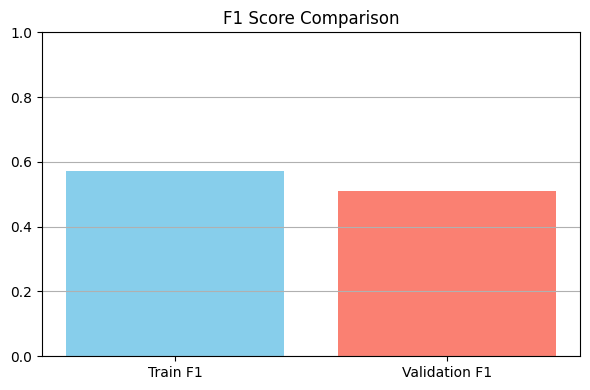

In [ ]:
y_pred_train = knn_model_cls.predict(X_train_cls)
y_pred_val = knn_model_cls.predict(X_val_cls)

train_f1 = f1_score(y_train_cls, y_pred_train)
val_f1 = f1_score(y_val_cls, y_pred_val)

plt.figure(figsize=(6,4))
plt.bar(["Train F1", "Validation F1"], [train_f1, val_f1], color=["skyblue", "salmon"])
plt.title("F1 Score Comparison")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

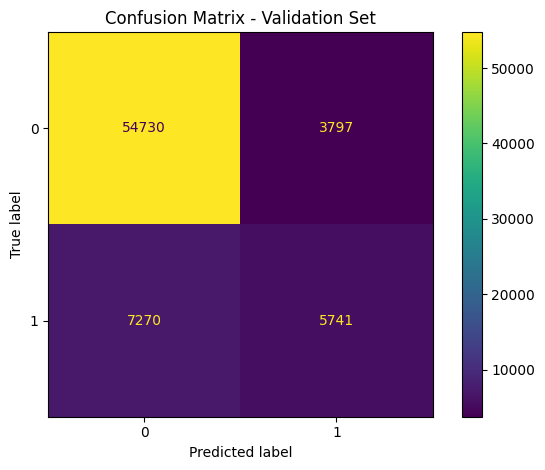

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_val_cls, y_pred_val)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix - Validation Set")
plt.tight_layout()
plt.show()

In [ ]:
# === Get predicted probabilities for each class ===
probs = knn_model_cls.predict_proba(X_val_cls)
prob_0 = probs[:, 0]
prob_1 = probs[:, 1]

# === Get predicted class labels ===
predicted_labels = knn_model_cls.predict(X_val_cls)

# Combine true and predicted labels with predicted probabilities
results_cls_df = pd.DataFrame({
    "true_label": y_val_cls,
    "predicted_label": predicted_labels,
    "probability_0": prob_0,   # Probability for class 0
    "probability_1": prob_1    # Probability for class 1
})

# Save to CSV without index
results_cls_df.to_csv("/content/drive/MyDrive/ERP/KNN/classification_results.csv", index=False)

# Preview
results_cls_df.head()

,true_label,predicted_label,probability_0,probability_1
0,0,0,1.000000,0.000000
1,0,0,1.000000,0.000000
2,0,1,0.384615,0.615385
3,0,0,0.923077,0.076923
4,0,0,1.000000,0.000000


## 5. Evaluate the model

In [13]:
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score,
    recall_score, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_knn_classifier(model, X, y, dataset_name="", threshold=0.3):
    """
    Evaluate a trained kNN classifier on given dataset.
    """
    # Predict probabilities and class labels
    prob = model.predict_proba(X)[:, 1]  # Probability of class 1
    preds = (prob > threshold).astype(int)     # Apply threshold

    # Metrics
    auc = roc_auc_score(y, prob)
    f1 = f1_score(y, preds)
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)
    conf_matrix = confusion_matrix(y, preds)

    # G-Mean
    tn, fp, fn, tp = conf_matrix.ravel()
    tpr = tp / (tp + fn + 1e-6)
    tnr = tn / (tn + fp + 1e-6)
    gmean = np.sqrt(tpr * tnr)

    # Print results
    print(f"\n--- Evaluation on {dataset_name} ---")
    print(f"AUC-ROC:     {auc:.4f}")
    print(f"F1-Score:    {f1:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Mean G-Mean: {gmean:.4f}")

    # Confusion matrix plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


--- Evaluation on Training Data ---
AUC-ROC:     0.9103
F1-Score:    0.6371
Precision:   0.5250
Recall:      0.8102
Confusion Matrix:
[[228634  44503]
 [ 11520  49187]]
Mean G-Mean: 0.8235


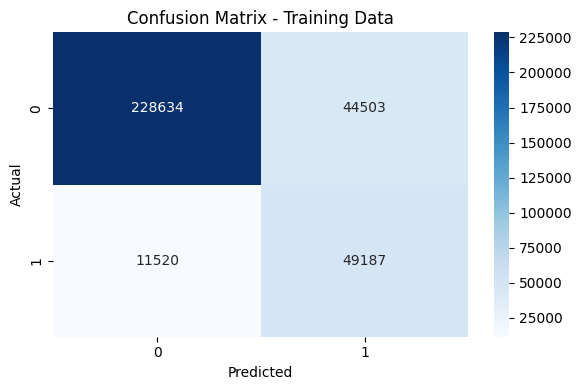


--- Evaluation on Validation Data ---
AUC-ROC:     0.8649
F1-Score:    0.5834
Precision:   0.4817
Recall:      0.7395
Confusion Matrix:
[[48172 10355]
 [ 3389  9622]]
Mean G-Mean: 0.7802


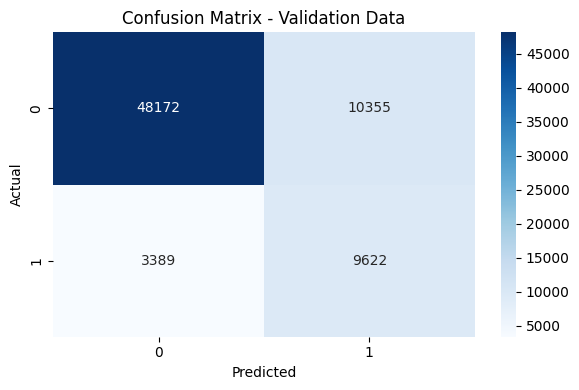


--- Evaluation on Test Data ---
AUC-ROC:     0.8690
F1-Score:    0.5928
Precision:   0.4895
Recall:      0.7514
Confusion Matrix:
[[48439 10149]
 [ 3220  9730]]
Mean G-Mean: 0.7882


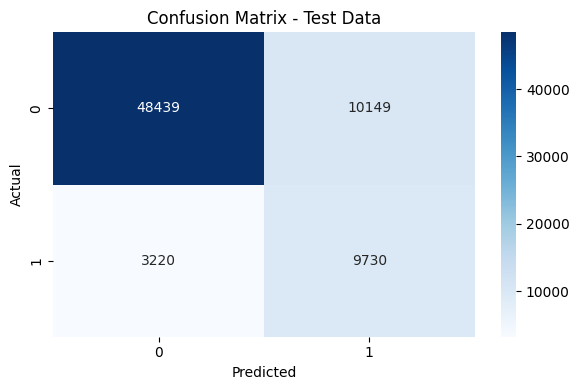

In [14]:
evaluate_knn_classifier(knn_model_cls, X_train_cls, y_train_cls, "Training Data")
evaluate_knn_classifier(knn_model_cls, X_val_cls, y_val_cls, "Validation Data")
evaluate_knn_classifier(knn_model_cls, X_test_cls, y_test_cls, "Test Data")


--- Evaluation on Test Data @ 0.3 ---
AUC-ROC:     0.8690
F1-Score:    0.5928
Precision:   0.4895
Recall:      0.7514
Confusion Matrix:
[[48439 10149]
 [ 3220  9730]]
Mean G-Mean: 0.7882


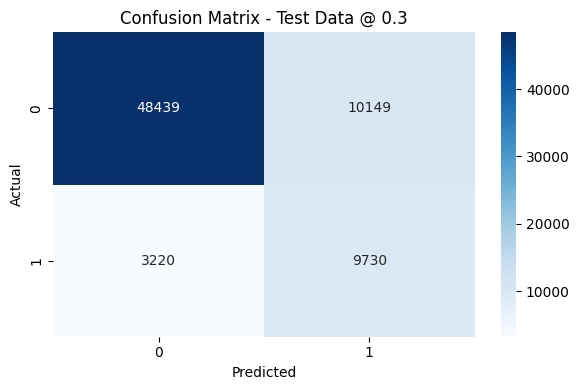


--- Evaluation on Test Data @ 0.5 ---
AUC-ROC:     0.8690
F1-Score:    0.5066
Precision:   0.6009
Recall:      0.4378
Confusion Matrix:
[[54822  3766]
 [ 7280  5670]]
Mean G-Mean: 0.6401


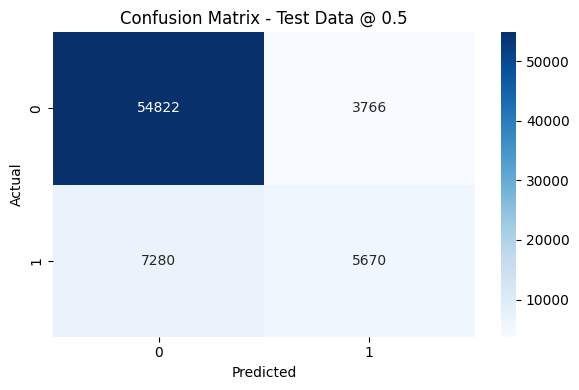


--- Evaluation on Test Data @ 0.1 ---
AUC-ROC:     0.8690
F1-Score:    0.5452
Precision:   0.3898
Recall:      0.9064
Confusion Matrix:
[[40214 18374]
 [ 1212 11738]]
Mean G-Mean: 0.7888


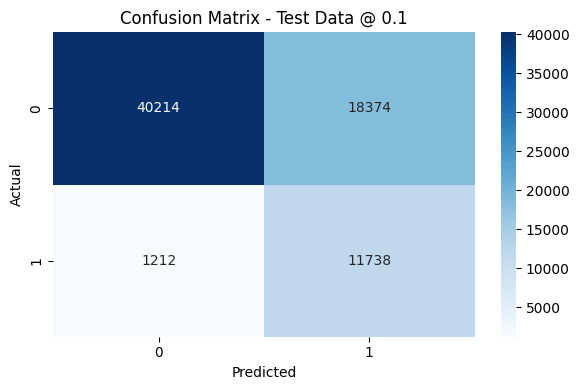

In [ ]:
evaluate_knn_classifier(knn_model_cls, X_test_cls, y_test_cls,  "Test Data @ 0.3", threshold=0.3)
evaluate_knn_classifier(knn_model_cls, X_test_cls, y_test_cls,  "Test Data @ 0.5", threshold=0.5)
evaluate_knn_classifier(knn_model_cls, X_test_cls, y_test_cls,  "Test Data @ 0.1", threshold=0.1)

## 6. Save the model

In [ ]:
import joblib
import pandas as pd

# Save trained kNN model
joblib.dump(knn_model_cls, "/content/drive/MyDrive/ERP/KNN/knn_cls_model.pkl")

# Save best hyperparameters as CSV
params_df = pd.DataFrame([best_params_cls])
params_df.to_csv("/content/drive/MyDrive/ERP/KNN/best_params_cls.csv", index=False)

# Save StandardScaler
#joblib.dump(scaler, "scaler.pkl")

## Optional: load the model

In [12]:
'''
# Load best hyperparameters from CSV
loaded_params_df = pd.read_csv("best_params_cls.csv")
best_params_cls = loaded_params_df.iloc[0].to_dict()

# Convert integer-like float values to int
best_params_cls['n_neighbors'] = int(best_params_cls['n_neighbors'])
best_params_cls['p'] = int(best_params_cls['p'])
'''

# Load trained kNN model
knn_model_cls = joblib.load("/content/drive/MyDrive/ERP/KNN/knn_cls_model.pkl")

# Load scaler
#scaler = joblib.load("scaler.pkl")